In [ ]:
import numpy as np
import geopandas as gpd
from scipy.spatial import KDTree
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from fuzzywuzzy import process
import contextily as cx

import warnings

from IndexUtils import * 
from TileUtils import *
from featurematching import *
from ReadDate import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
from scipy.spatial.distance import cdist
import easyocr
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.ndimage import center_of_mass

from sklearn.cluster import DBSCAN

from skimage.morphology import skeletonize

from scipy.interpolate import Rbf


In [ ]:
corners = gpd.read_file(r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\OSM_Roads\TexasRoads_filtered_strict_3857_nondupe_smaller_harris.gpkg")
roads_gdf = gpd.read_file(r"C:\Users\fhacesga\Downloads\TexasRoads_filtered_strict_3857.gpkg", engine='pyogrio', use_arrow=True)

corner_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp4\pickles\\"

referencing_dir  = r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing_2\\"
registration_dir = r"D:\RECTDNN\processing\2024-10-11_15-08-46\registration\\"

descriptor_kwds = {
    "angle_step"        : 5,
    "azimuth_radius"    : 500
}

corners, _ = calcDescriptors(corners, **descriptor_kwds)

  0%|          | 0/127256 [00:00<?, ?it/s]

In [ ]:
with open("SmartDictV2.p", 'rb') as f:
    tile_coords = pickle.load(f)

In [ ]:
def iterativeAdjustFromMatching(matchresults, corners_curr=None, idx=None, im_corner_gdf=None, plot=False, verbose=False, dbscan_eps=0.03):
    if idx is None:
        idx = np.arange(len(matchresults), dtype=np.int32)
    
    if len(matchresults[0]) > 4:
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[4][0] for x in matchresults], [x[4][1] for x in matchresults]))
        toPoints   = gpd.GeoDataFrame(geometry=gpd.points_from_xy([x[5][0] for x in matchresults], [x[5][1] for x in matchresults]))
    else:
        fromPoints = np.vstack((np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.x), np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.y))).T
        toPoints = np.vstack((np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.x), np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.y))).T
        # fromPoints = np.vstack((np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.x), np.array(im_corner_gdf.iloc[np.array(matchresults)[idx, 0]].geometry.y))).T
        # toPoints = np.vstack((np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.x), np.array(corners_curr.iloc[np.array(matchresults)[idx, 1]].geometry.y))).T
        fromPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(fromPoints[:, 0], fromPoints[:, 1]))
        toPoints = gpd.GeoDataFrame(geometry=gpd.points_from_xy(toPoints[:, 0], toPoints[:, 1]))

    coordsA = getCoordsGDF(fromPoints)
    coordsB = getCoordsGDF(toPoints)

    coordsA, coordsB = normCoords(coordsA, coordsB)

    i = 0

    checker = True
    prev = np.where(idx)[0].shape[0]

    if plot:
            plotMatches(fromPoints, toPoints, dbscan_eps=dbscan_eps)
    while checker:
        initial = affineTransformation(coordsA[idx, 0], coordsA[idx, 1], coordsB[idx, 0], coordsB[idx, 1],verbose=False)
        matrix = initial.matrix        
        coordsBprime = np.hstack((coordsB[idx], np.ones((coordsB[idx].shape[0], 1)))) @ np.linalg.inv(matrix).T


        distances = np.sqrt((coordsBprime[:, 0] - coordsA[idx, 0]) ** 2 + (coordsBprime[:, 1] - coordsA[idx, 1]) ** 2)
        uv = coordsB - coordsA
        angles = np.degrees(np.arctan2(uv[:, 1], uv[:, 0]))
        test = np.vstack((normArry(angles), normArry(np.sqrt(uv[:, 0] ** 2, uv[:, 1] ** 2 )))).T
        test[np.isnan(test)] = 0
        idx = most_popular_indices_2d(test, eps=dbscan_eps)

        

        if np.where(idx)[0].shape[0] < prev:
            prev = np.where(idx)[0].shape[0]
        else: 
            checker = False
        
        if verbose:
            print(i)
            print(np.linalg.inv(matrix).T)
            fig, axs = plt.subplots(1, 2)
            axs[0].scatter(coordsA[idx, 0], coordsA[idx, 1], color='black')
            axs[0].scatter(coordsB[idx, 0], coordsB[idx, 1])
            axs[0].scatter(coordsBprime[:, 0], coordsBprime[:, 1], marker='x')
            axs[1].hist(distances, bins=50)
            axs[1].set_title(f"Iteration {i}")
            plt.show()

        i = i + 1

    return matrix, distances

def registerImagesV1(ra, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, 
                     r_initial=500, 
                     verbose=1, 
                     distance_threshold=2,
                     n_iters=50):
    compoundedAdjustment = np.eye(3)
    flip=np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
        ]) 
    

    for i in range(n_iters):
        
        r_current = r_initial * 0.9 ** i

        if i == 0:
            matching_results, im_corner_gdf, corners_curr = matching(im_corner_gdf, corners_curr, ratio_threshold=0.8, **descriptor_kwds)
            if len(matching_results) < 3:
                raise(Exception(f"Cannot match: {len(matching_results)} matches found for {ra.path}"))
            matrix, distances = iterativeAdjustFromMatching(matching_results, corners_curr=corners_curr, im_corner_gdf=im_corner_gdf, plot=verbose>3, verbose=verbose>8)
        else:
            matching_results, _, _ = matching_distances(im_corner_gdf_adj, corners_curr, match_radius=r_current, ratio_threshold=0.9, **descriptor_kwds)
            matrix, distances = iterativeAdjustFromMatching(matching_results, plot=verbose>3)

        compoundedAdjustment = np.linalg.inv(matrix) @ compoundedAdjustment 

        rev_adj = compoundedAdjustment @ flip
        current_adjustment = getMatrixFromAffine(ra.transform) @ flip @ rev_adj

        reprojectedcorners = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @ current_adjustment.T

        scale = np.sqrt(0.5 * (matrix[0,0] ** 2 + matrix[1,1] ** 2))
        translation = np.sqrt(matrix[0,2] ** 2 + matrix[1,2] ** 2)
        conv_check = np.abs(1 - scale) < 0.002 or translation < 30

        if verbose > 5:
            print(f"Scale {scale:.3e}")
            print(f"Translation {translation:.3e}")
            print(conv_check)
            print(rev_adj)

        if verbose > 10:
            plt.figure()
            plt.scatter(reprojectedcorners[:, 0], reprojectedcorners[:, 1])
            test = np.hstack((corner_arry, np.ones((corner_arry.shape[0], 1)))) @  getMatrixFromAffine(ra.transform).T
            plt.scatter(test[:, 0], test[:, 1])
            plt.show()

        im_corner_gdf_adj = im_corner_gdf.copy()
        im_corner_gdf_adj['geometry'] = gpd.points_from_xy(reprojectedcorners[:,0], reprojectedcorners[:, 1])

        # return im_corner_gdf_adj

        if verbose > 0:
            print(np.nanpercentile(distances, [0, 25, 50, 75, 100]), len(matching_results))

        if np.nanpercentile(distances, 50) < distance_threshold or conv_check:
            return current_adjustment        

    return current_adjustment

Processing 48201C0290H--------------------------------------------------
1718 / 1718
Using 1992-09-30 00:00:00 for tile date 1992-09-30 00:00:00


  0%|          | 0/1716 [00:00<?, ?it/s]

  0%|          | 0/1716 [00:00<?, ?it/s]

0
[[     3.0178    -0.57416           0]
 [    -1.9107      3.1786           0]
 [     1456.6      1142.6           1]]


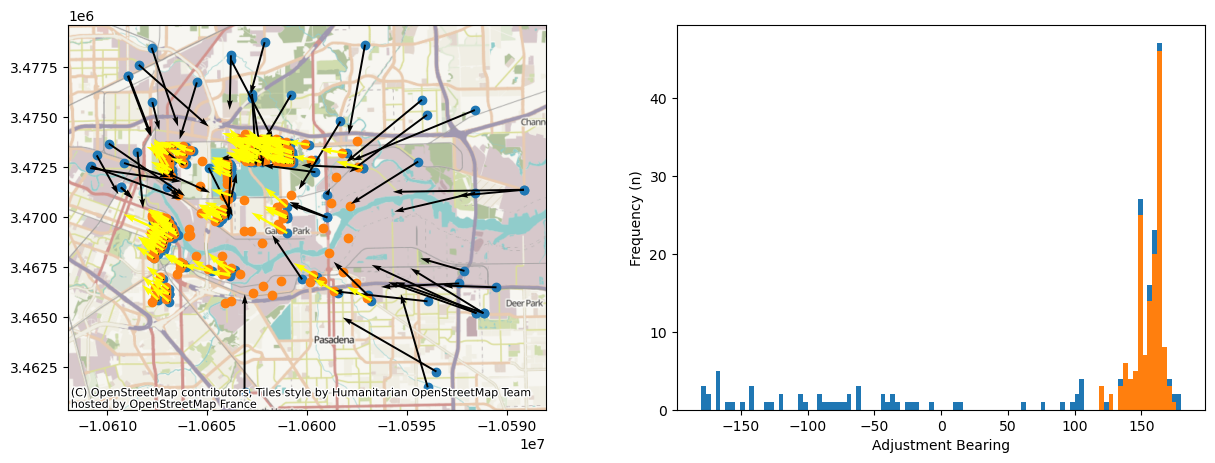

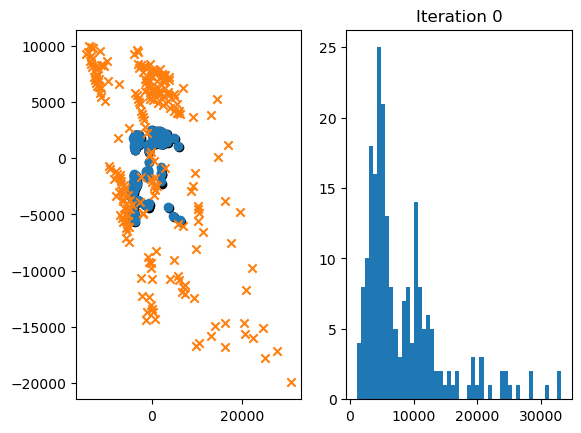

1
[[     1.0094   0.0015556           0]
 [  -0.005681      1.0067           0]
 [     184.13     -80.087           1]]


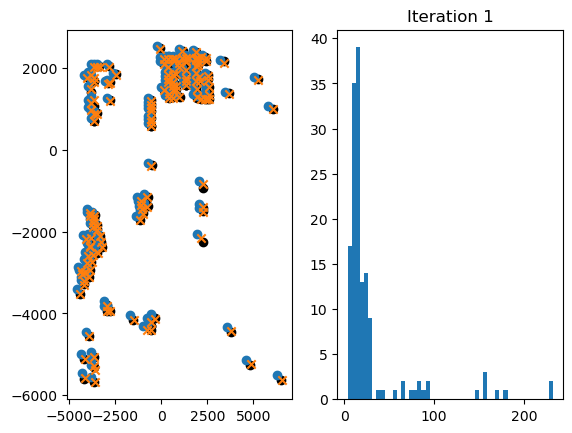

Scale 7.015e-01
Translation 1.987e+02
False
[[     1.0094    0.005681      184.13]
 [  0.0015556     -1.0067     -80.087]
 [          0           0           1]]
[      3.593       11.43      15.211      23.506      231.88] 218


  0%|          | 0/1716 [00:00<?, ?it/s]

  0%|          | 0/12783 [00:00<?, ?it/s]

Scale 7.061e-01
Translation 4.820e+01
False
[[     1.0079    0.001708      135.87]
 [ 0.00053793      -1.011     -74.118]
 [          0           0           1]]
[    0.59722      7.5643      11.843      16.471       56.94] 1070


  0%|          | 0/1716 [00:00<?, ?it/s]

  0%|          | 0/12783 [00:00<?, ?it/s]

Scale 7.069e-01
Translation 5.765e+01
False
[[     1.0082   0.0018527      154.56]
 [ -0.0016588     -1.0113     -19.912]
 [          0           0           1]]
[     1.6244       29.35      35.903      41.444      341.67] 1061


  0%|          | 0/1716 [00:00<?, ?it/s]

  0%|          | 0/12783 [00:00<?, ?it/s]

Scale 7.065e-01
Translation 5.766e+01
False
[[     1.0082    0.002362      157.99]
 [ -0.0038179     -1.0131     -77.945]
 [          0           0           1]]
[      11.19      35.103      41.924      56.316      313.51] 1066


  0%|          | 0/1716 [00:00<?, ?it/s]

  0%|          | 0/12783 [00:00<?, ?it/s]

Scale 7.078e-01
Translation 8.169e+01
False
[[     1.0082   0.0017134       153.4]
 [  -0.001719     -1.0112       3.928]
 [          0           0           1]]
[    0.17627      23.927      29.788      36.077      252.23] 1078


  0%|          | 0/1716 [00:00<?, ?it/s]

  0%|          | 0/12783 [00:00<?, ?it/s]

Scale 7.065e-01
Translation 5.650e+01
False
[[      1.008   0.0017442      157.08]
 [-0.00068869     -1.0129     -52.376]
 [          0           0           1]]
[     2.7725      19.063      28.707      39.899       237.4] 1099


  0%|          | 0/1716 [00:00<?, ?it/s]

  0%|          | 0/12783 [00:00<?, ?it/s]

Scale 7.076e-01
Translation 4.163e+01
False
[[     1.0081   0.0016508      156.31]
 [ -0.0019891     -1.0113     -10.936]
 [          0           0           1]]
[     1.2484      21.895      28.024       33.78      221.83] 1118


  0%|          | 0/1716 [00:00<?, ?it/s]

In [ ]:
# r"D:\RECTDNN\processing\2024-10-11_15-08-46\referencing\48201C0930J.tif"
# tile_name = f"48201C0660L"
# tile_name = f"48201C0930J"
# tile_name = f"48201C0530J"
# tile_name = f"48201C0150G"
# tile_name = f"48201C0290H"

try:
    reader
except:
    reader = easyocr.Reader(['en']) 

for tile_name in ["48201C0290H", "48201C0930J", "48201C0530J", "48201C0660L"]:
    print(f"Processing {tile_name}" + "-" * 50)
    with open(f"{corner_dir}{tile_name}.pickle", 'rb') as f:
        x = pickle.load(f)    
        corner_bbox = [a.bbox.to_xyxy() for a in x if a.score.value > 0.001]
        corner_arry = np.array([calcCenter(a) for a in corner_bbox ]) * 2
        print(f"{len(corner_bbox)} / {len(x)}")

    im_file    = r"D:\RECTDNN\uncompress\\" + tile_name + ".tif"
    # him_file   = r"D:\RECTDNN\processing\2024-10-11_15-08-46\half_size\\" + tile_name + ".tif"

    curr_tn = os.path.basename(im_file.split(".")[0])[:-1]
    curr_tf = os.path.basename(im_file.split(".")[0])[-1]

    ra = rio.open(im_file)
    bounds  = ra.bounds
    image   = ra.read(1)

    bounds, RLNN = findBounds(im_file, None)

    if len(bounds[0]) < 1:
        print(f"COULD NOT FIND BOUNDS, USING IMAGE EXTENTS {tile_name}")
        bbox = [0, 0, image.shape[0], image.shape[1]]
        datebox = [ int(image.shape[1] * 0.75), int(image.shape[0] * 0.75), image.shape[1], image.shape[0]]
    else:
        bbox = bounds[0].boxes.xyxy.numpy().astype(np.int32)[0].flatten()
        # ASSUME DATE IS IN LOWER RIGHT OF IMAGE
        datebox = [bbox[2], int(3 * image.shape[0] // 4), image.shape[1], image.shape[0]]

    current_tile_coords = tile_coords.get(curr_tn, None)
    if current_tile_coords is None:
        raise(Exception(f"Could not find tile in detections {curr_tn}"))
    
    
    """
    current_tf_coords = current_tile_coords.get(curr_tf, None)
    if current_tf_coords is None:
        # warnings.warn(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default")
        print(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default {list(current_tile_coords.keys())[0]} from options {current_tile_coords.keys()}")
        curr_tf = list(current_tile_coords.keys())[0]
    """
    # GET DATE OF CURRENT TILE
    tile_datetime = extractDate(image[datebox[1]:datebox[3], datebox[0]:datebox[2]], reader, imsize=4092, filter_values=['revised', 'effective'])

    if tile_datetime[0] is not None: 
        # IF FOUND, FIND CLOSEST DATE WITHIN CURRENT KEY
        curr_bbox, closest_date = getBBOXClosestDate(extractDatesFromDict(tile_coords[curr_tn], curr_tf), tile_datetime[0][0])

        # IF CLOSEST DATE WITHIN CURRENT KEY IS OVER 10 YEARS, RETRY WITH ENTIRE DICT
        if abs(closest_date - tile_datetime[0][0]).days > 3650:
            curr_bbox, closest_date_gen = getBBOXClosestDate(extractDatesFromDict(tile_coords[curr_tn], 0), tile_datetime[0][0])
            print(f"CLOSEST DATE IN KEY IS TOO FAR ({abs(closest_date - tile_datetime[0][0]).days} days), using general instead ({closest_date_gen})")
    else: 
        print(f"Could not find date in {tile_datetime[1]}")
        # IF NOT FOUND, USE DEFAULT (0)
        current_tf_coords = current_tile_coords.get(curr_tf, None)
        if current_tf_coords is None:
            print(f"Could not find tile extension in detections {curr_tn} - {curr_tf}, using default {list(current_tile_coords.keys())[0]} from options {current_tile_coords.keys()}")
            curr_tf = list(current_tile_coords.keys())[0]
            curr_bbox = tile_coords[curr_tn][curr_tf]["coords"][0]

    real_x, real_y = bbox_to_coords_realworld(curr_bbox)
    pic_x, pic_y   = bbox_to_coords_raster(bbox)

    affine = affineTransformation(pic_x, pic_y, real_x, real_y)
    transform = bboxTransformToCRS(affine.matrix, image)

    ref_dir = f"{referencing_dir}{tile_name}.tif"

    with rio.open(ref_dir, 'w',
        driver='GTiff', count=1, dtype=image.dtype,
        height=image.shape[0], width=image.shape[1],
        crs=f'EPSG:3857',
        transform=rio.Affine(*transform.flatten()[:6])) as dst:
            dst.write(image, 1) 

    ra_ref = rio.open(ref_dir)
    corner_arry = np.int32(corner_arry)                 # CONVERT TO INT32
    corner_arry = cleanCenterBBOX(corner_arry, bbox)

    # USE RASTER TRANSFORM TO GET REAL-WORLD ESTIMATES OF STREET CORNERS
    im_corner_gdf = pointsToGeodataFrame(ra_ref, corner_arry[:, 1], corner_arry[:, 0])

    bounds_poly = enlarged_bounds(ra_ref, n=2)
    corners_curr = gpd.clip(corners, bounds_poly)

    prev_transform = getMatrixFromAffine(ra_ref.transform)
    
    try:
        current_adjustment = registerImagesV1(ra_ref, im_corner_gdf, corners_curr, corner_arry, descriptor_kwds, verbose=10)

        with rio.open(f"{registration_dir}{tile_name}.tif", 'w',
                        driver='GTiff', count=1, dtype=np.uint8,
                        height=image.shape[0], width=image.shape[1],
                        crs=f'EPSG:3857',
                        compress= 'CCITTFAX4',  # Use CCITTFAX4 or CCITTRLE for binary data compression
                        transform=rio.Affine(*current_adjustment.flatten()[:6])) as dst:
                            dst.write(image, 1) 
        
        ra_ref.close()
    except Exception as e:
        ra_ref.close()
        print(e)
        continue